In [1]:
import matplotlib.pyplot as plt
import math
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import trange, tqdm

from utils.distributions import SumOfGaussians
from score_based_sampling.train_score_model import train_score_model
import score_based_sampling.models as models
from utils.plotting_utils import create_3d_hist, create_2d_hist

gpu_id = 0
device = torch.device(f'cuda:{gpu_id}')

#define our distribution
mean0 = torch.FloatTensor([2, 2])
mean1 = torch.FloatTensor([-1, 1])
d = len(mean0)

covar0 = torch.FloatTensor([[2, 0], [0, 1]])
covar1 = torch.FloatTensor([[0.5, 0.0], [0, 3]])

mixing_parameter = 0.4
sog_dis = SumOfGaussians([mean0, mean1], [covar0, covar1], [mixing_parameter, 1.0 - mixing_parameter])


In [2]:
N_train = 500_000
train_samples = sog_dis.sample(N_train)

N_val = 10_000
val_samples = sog_dis.sample(N_val)

train_bs = 1024
val_bs = 4096

class SamplesDataset(Dataset):
    def __init__(self, samples):
        super().__init__()
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        #return dummy target
        return self.samples[i], 0

train_dataset = SamplesDataset(train_samples)
val_dataset = SamplesDataset(val_samples)

train_loader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=val_bs)

In [3]:
#Multiple Noise scales
max_sigma = 5
min_sigma = 0.001
N_noise_scales = 100

#geometric series with common ratio gamma
gamma = (min_sigma / max_sigma) ** (1 / (N_noise_scales - 1))
sigmas = max_sigma * gamma ** (torch.arange(0, N_noise_scales))
sigmas = sigmas.to(device)

print(f'Max sigma {max_sigma:.3f} - Min Sigma {min_sigma:.3f} - Num scales {N_noise_scales} - Gamma {gamma:.3f}')


Max sigma 5.000 - Min Sigma 0.001 - Num scales 100 - Gamma 0.918


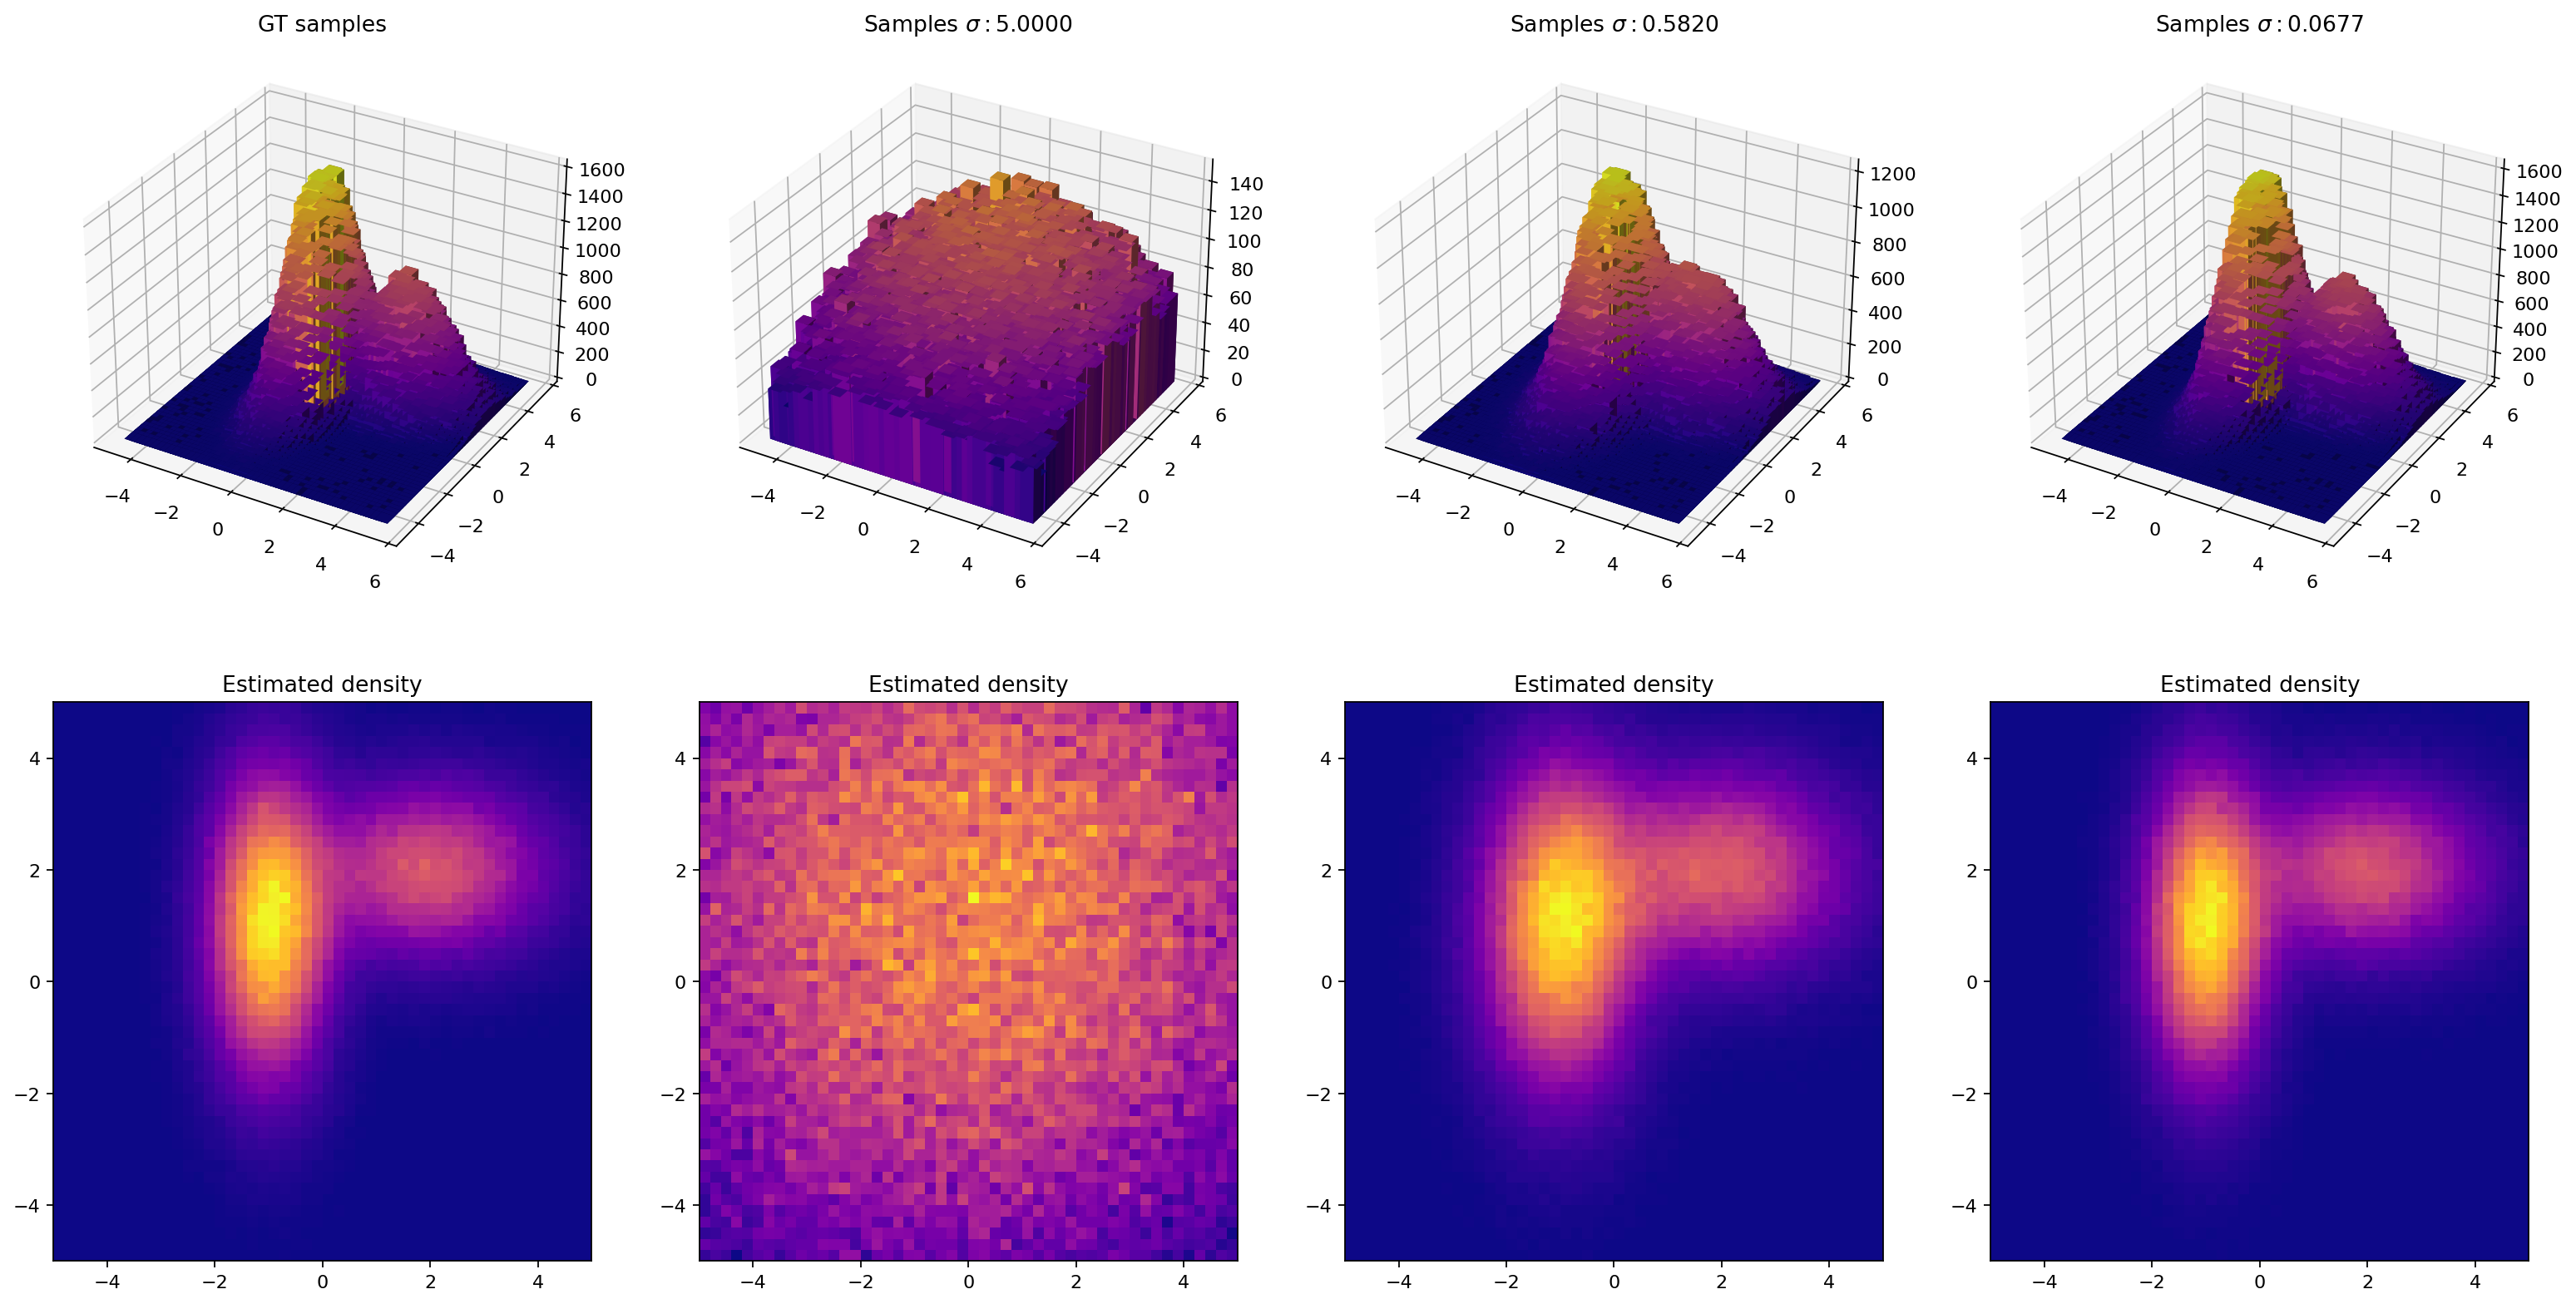

In [4]:
#Visualise smoothed distributions
#exact samples
num_samples = 500_000
gt_samples = sog_dis.sample(num_samples)

num_plot_noisy_distributions = 3
num_plot_rows = 2
num_plot_cols = num_plot_noisy_distributions + 1

x_min = -5
x_max = 5
y_min = -5
y_max = 5

fig = plt.figure(figsize=(num_plot_cols * 6, num_plot_rows*6), dpi=160)

subplot_base_size = 100 * num_plot_rows + 10 * num_plot_cols
plot_sigma_stepsize = int(math.floor(N_noise_scales / (num_plot_noisy_distributions + 1)))
plot_sigma_idcs = torch.arange(0, N_noise_scales, plot_sigma_stepsize)[:num_plot_noisy_distributions]

for i in range(num_plot_cols):
    if i == 0:
        samples = gt_samples
        title = 'GT samples'
        sigma = 0
    else:
        #sample from noisy distributions
        sigma = sigmas[plot_sigma_idcs[i - 1]]
        samples = gt_samples + sigma.cpu() * torch.randn_like(gt_samples)
        title = f'Samples $\sigma: {sigma:.4f}$'

    subplot_idx = subplot_base_size + i + 1
    ax = fig.add_subplot(subplot_idx, projection='3d')
    create_3d_hist(ax, samples, x_min, x_max, y_min, y_max)
    ax.set_title(title)

    subplot_idx = subplot_base_size + i + num_plot_cols +  1
    ax = fig.add_subplot(subplot_idx)
    create_2d_hist(ax, samples, x_min, x_max, y_min, y_max)
    ax.set_title('Estimated density')


In [5]:
#load our model
epochs = 20
lr = 0.02
optim = 'sgd'

model = models.get_large_NDFC(d,d, sigmas=sigmas)
model.to(device)

print('Starting score net training...')

train_score_model(model, sigmas, train_loader, lr, epochs, device, optim=optim, val_loader=val_loader)

print('Training done')

Starting score net training...
Epoch 0 - Avg train loss 0.8671584129333496
Val loss 0.8545398116111755
Epoch 1 - Avg train loss 0.8518338203430176
Val loss 0.8502206206321716
Epoch 2 - Avg train loss 0.8505499362945557
Val loss 0.8519224524497986
Epoch 3 - Avg train loss 0.8465303778648376
Val loss 0.8510107398033142
Epoch 4 - Avg train loss 0.8497198820114136
Val loss 0.8507056832313538
Epoch 5 - Avg train loss 0.8490721583366394
Val loss 0.8484066724777222
Epoch 6 - Avg train loss 0.8485112190246582
Val loss 0.8491987586021423
Epoch 7 - Avg train loss 0.8496161103248596
Val loss 0.8470609188079834
Epoch 8 - Avg train loss 0.8504636287689209
Val loss 0.8495061993598938
Epoch 9 - Avg train loss 0.8453695774078369
Val loss 0.8502802848815918
Epoch 10 - Avg train loss 0.8458071947097778
Val loss 0.8497400879859924
Epoch 11 - Avg train loss 0.8476207256317139
Val loss 0.84876549243927
Epoch 12 - Avg train loss 0.8503134846687317
Val loss 0.8459285497665405
Epoch 13 - Avg train loss 0.8484

100%|██████████| 20/20 [00:01<00:00, 13.18it/s]


Text(0.5, 1.0, 'Estimated scores')

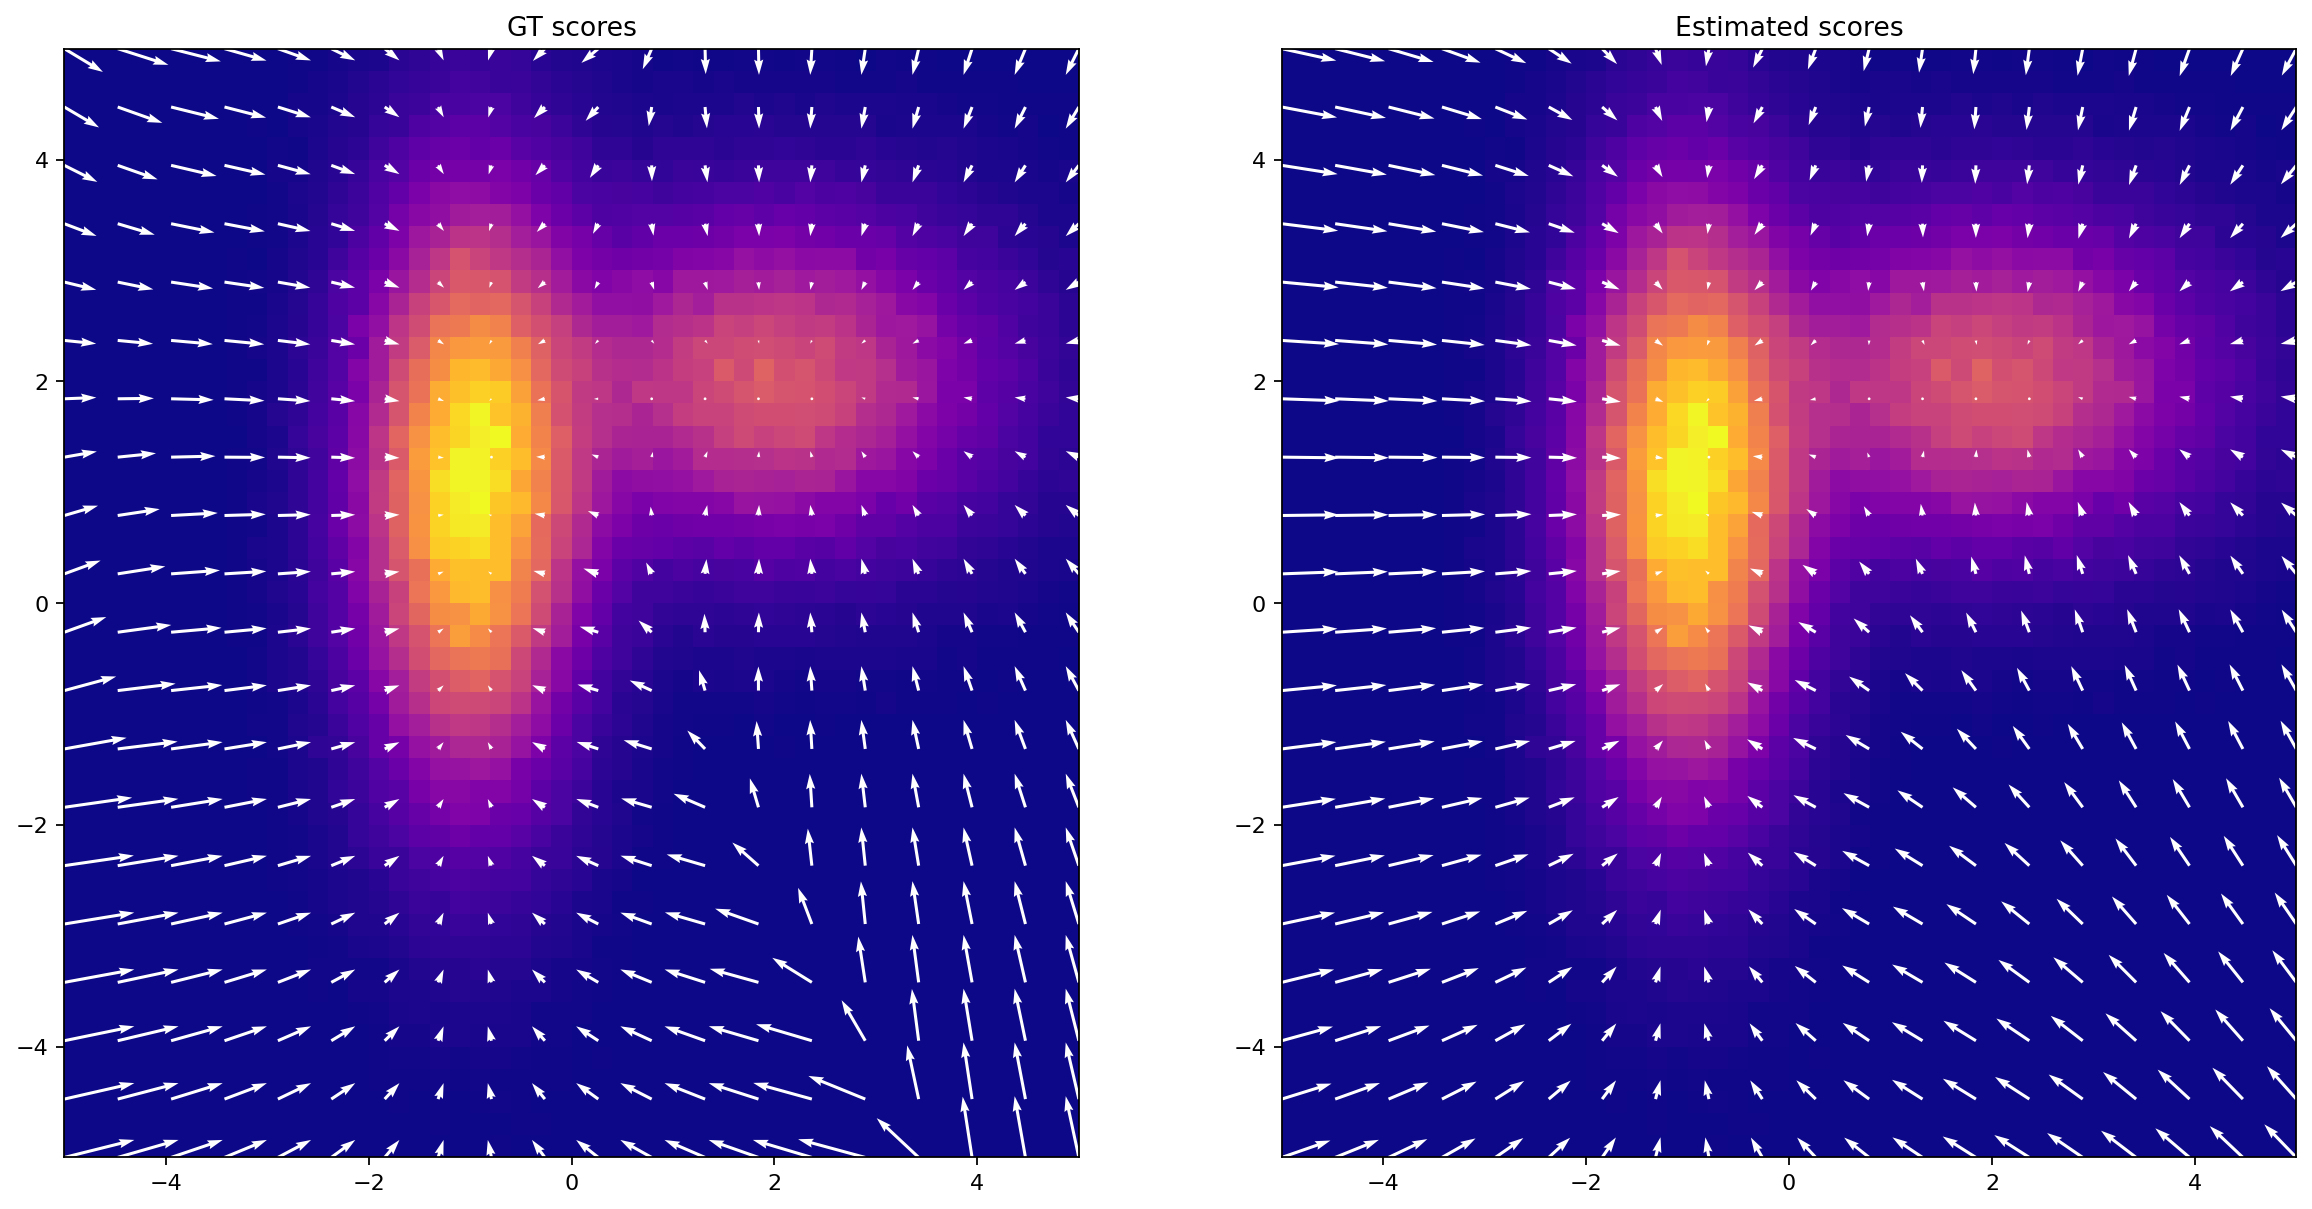

In [6]:
#compare score vector fields
subdivs = 20

grid_x, grid_y = torch.meshgrid(torch.linspace(x_min, x_max,subdivs), torch.linspace(y_min, y_max,subdivs), indexing='ij')

gt_scores = torch.zeros((grid_x.shape[0], grid_x.shape[1], d))
learned_scores =  torch.zeros((grid_x.shape[0], grid_x.shape[1], d))

plot_signa_idx = len(sigmas) - 1

for i in trange(grid_x.shape[0]):
        for j in range(grid_x.shape[1]):
            xy = torch.FloatTensor([grid_x[i,j],grid_y[i,j]]).requires_grad_(True)
            with torch.enable_grad():
                log_prob = sog_dis.log_prob(xy)
                torch.sum(log_prob).backward()
                score = xy.grad.detach()
                gt_scores[i,j] = score.detach().cpu()

            with torch.no_grad():
                xy = xy[None,:].to(device)
                noise_scale_idcs = plot_signa_idx * torch.ones(len(xy), dtype=torch.long, device=device)
                learned_scores[i,j] = model(xy, noise_scale_idcs).detach().cpu()

#plot scores
fig = plt.figure(figsize=(18, 9), dpi=160)
ax = fig.add_subplot(121)
create_2d_hist(ax,  gt_samples, x_min, x_max, y_min, y_max)
ax.quiver(grid_x, grid_y, gt_scores[:, :, 0], gt_scores[:, :, 1], color='white')
ax.set_title('GT scores')

ax = fig.add_subplot(122)
create_2d_hist(ax,  gt_samples, x_min, x_max, y_min, y_max)
ax.quiver(grid_x, grid_y, learned_scores[:, :, 0], learned_scores[:, :, 1], color='white')
ax.set_title('Estimated scores')

In [7]:
#Langevin samples - Single Noise Scale
sampling_steps = 1_000
time_step = 1.0
sample_noise_scale = min_sigma

#https://abdulfatir.com/blog/2020/Langevin-Monte-Carlo/
#https://en.wikipedia.org/wiki/Stochastic_gradient_Langevin_dynamics
s_samples = 2 * torch.randn((num_samples, d), device=device)

with torch.no_grad():
    for k in trange(sampling_steps):
        noise_scale_idcs = plot_signa_idx * torch.ones(len(s_samples), dtype=torch.long, device=device)
        score = model(s_samples, noise_scale_idcs)

        noise = torch.randn((num_samples,d), device=device)

        step_k = time_step * (0.5 + math.cos(math.pi * k / sampling_steps) / 2)
        s_samples = s_samples + step_k * score + math.sqrt(2 * step_k) * noise

s_samples = s_samples.detach().cpu()


100%|██████████| 1000/1000 [00:43<00:00, 23.14it/s]


In [8]:
#Langevin samples - Multiple Noise Scales
sampling_steps_per_noise_scale = 10
time_step = 1.0

#https://abdulfatir.com/blog/2020/Langevin-Monte-Carlo/
#https://en.wikipedia.org/wiki/Stochastic_gradient_Langevin_dynamics
ns_samples = 2 * torch.randn((num_samples, d), device=device)

k = 0
with torch.no_grad():
    for sigma_idx, sigma in tqdm(enumerate(sigmas)):
        noise_scale_idcs = sigma_idx * torch.ones(len(ns_samples), dtype=torch.long, device=device)

        for _ in range(sampling_steps_per_noise_scale):
            step_k = time_step * (0.5 + math.cos(math.pi * k / (sampling_steps_per_noise_scale * len(sigmas))) / 2)
            k += 1

            score = model(ns_samples, noise_scale_idcs)

            noise = torch.randn((num_samples,d), device=device)
            ns_samples = ns_samples + step_k * score  + math.sqrt(2*step_k) * noise


ns_samples = ns_samples.detach().cpu()


100it [00:43,  2.29it/s]


Text(0.5, 1.0, 'Estimated density - Multi Scale Score Net Langevin Samples')

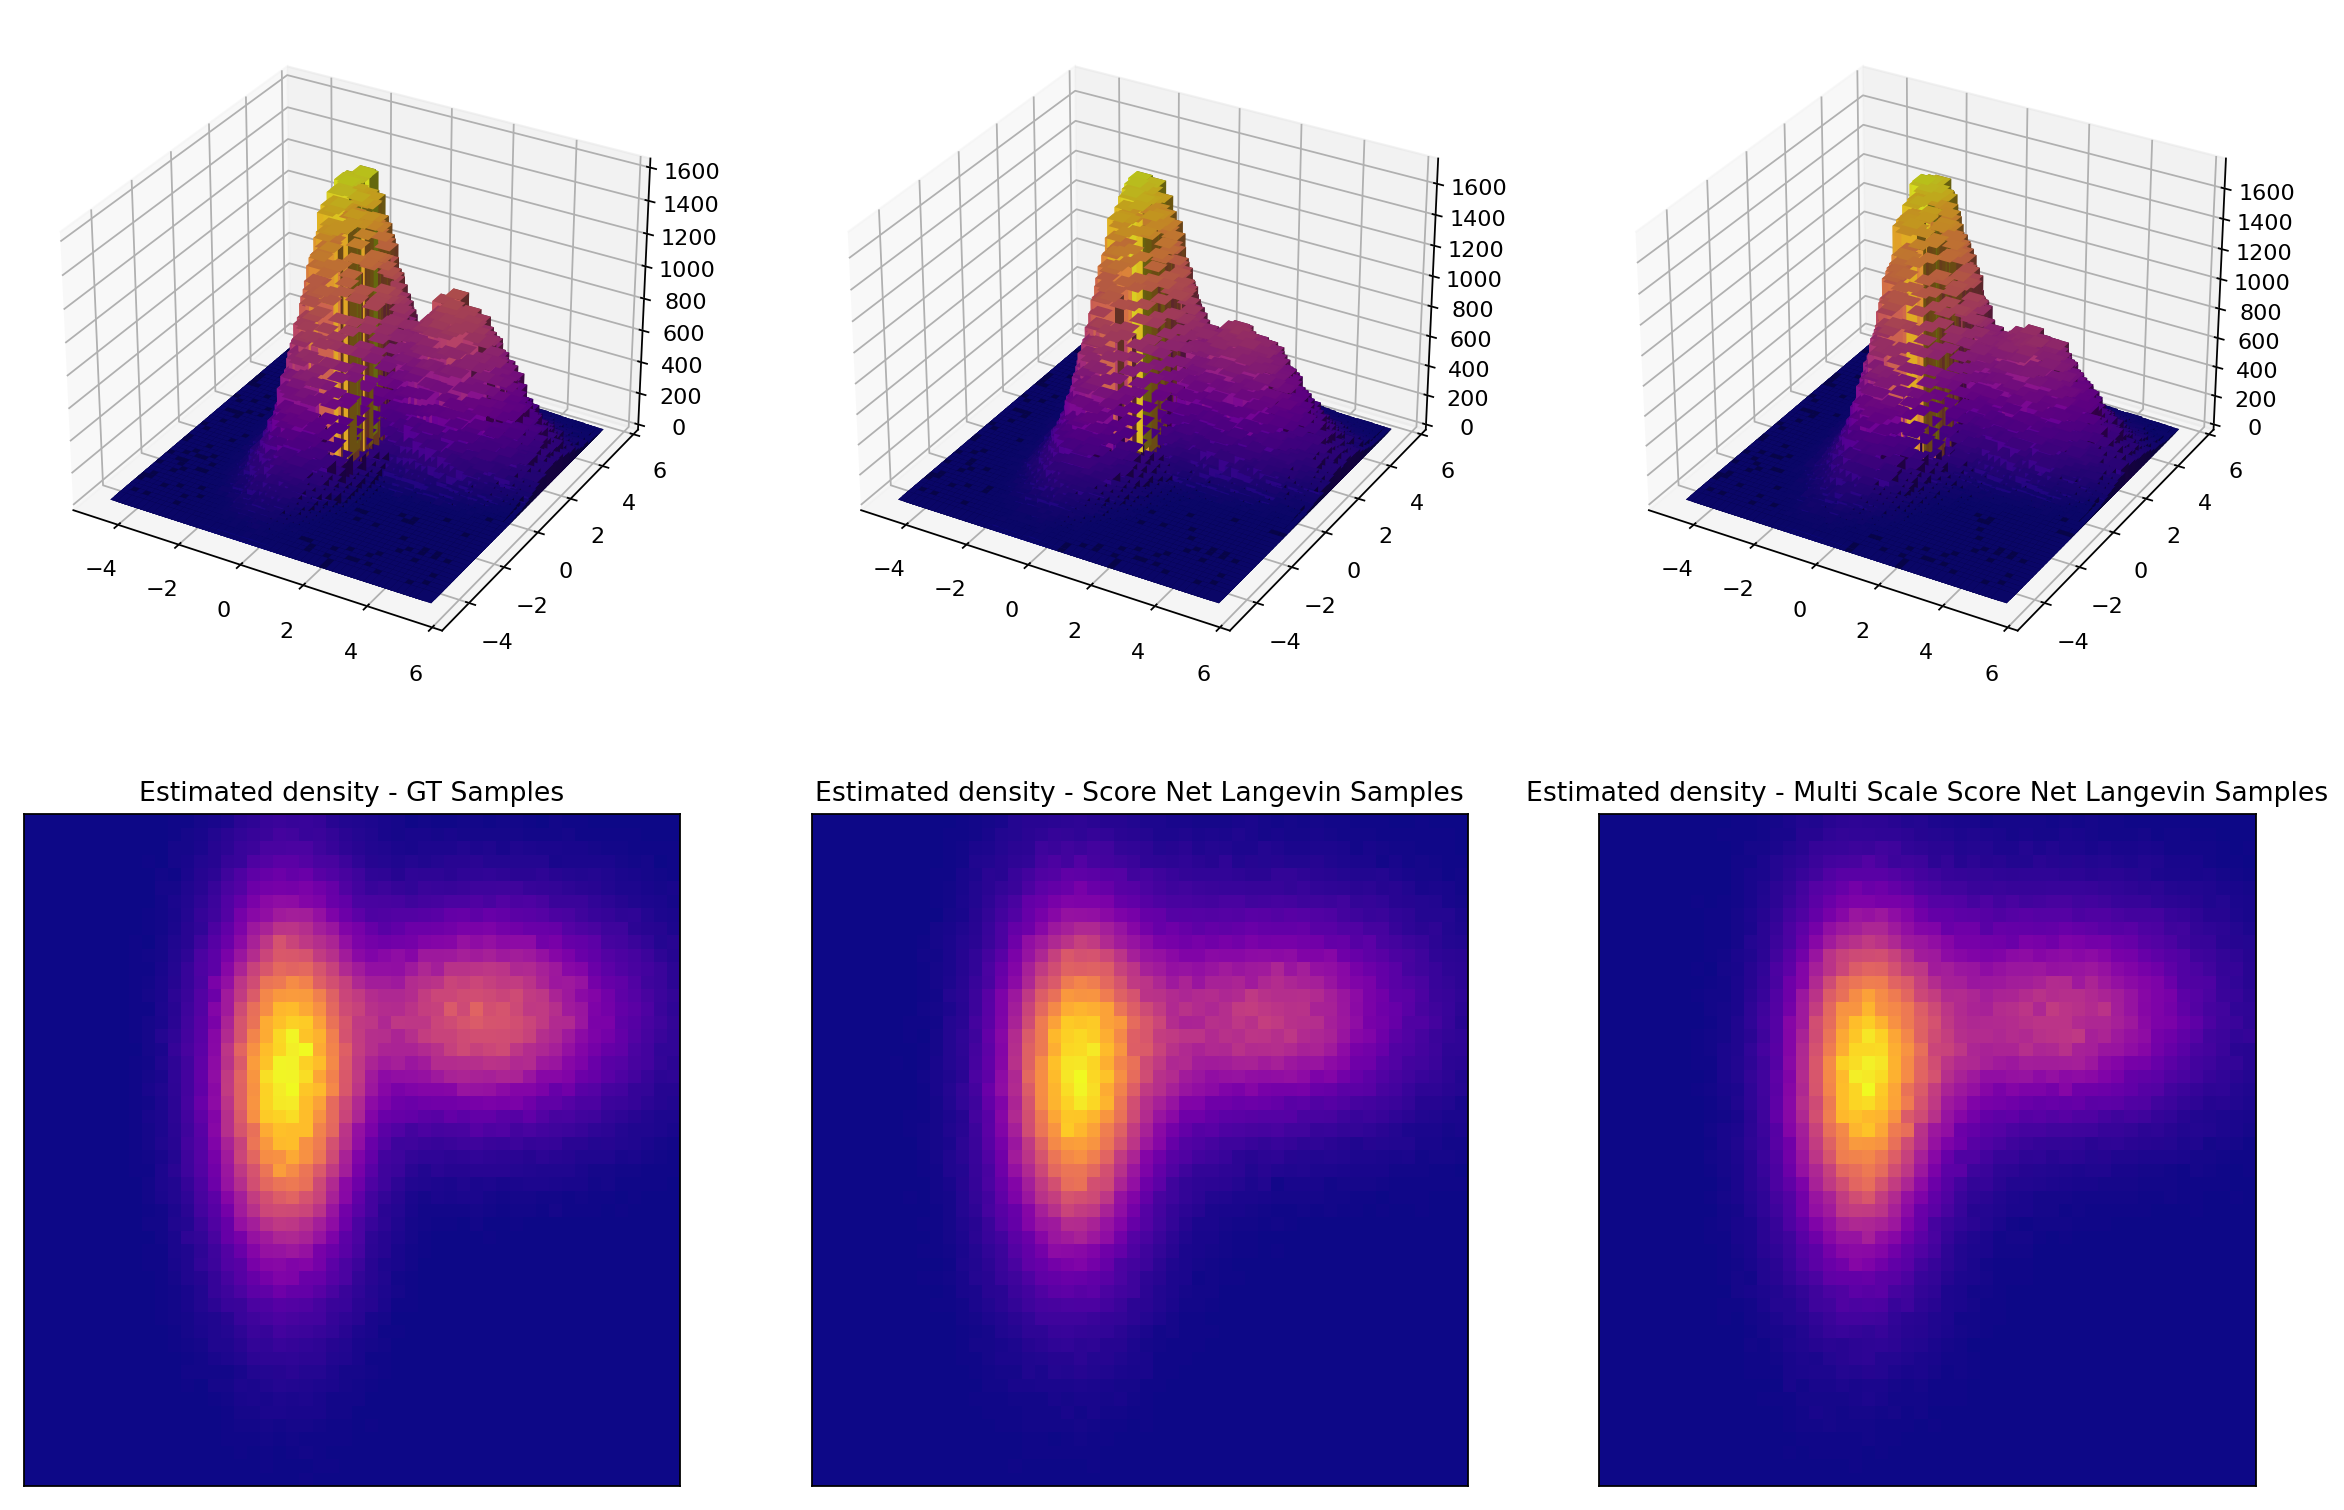

In [9]:
#visualize samples
fig = plt.figure(figsize=(18, 12), dpi=160)
ax = fig.add_subplot(231, projection='3d')
create_3d_hist(ax, gt_samples, x_min, x_max, y_min, y_max)

ax = fig.add_subplot(232, projection='3d')
create_3d_hist(ax, s_samples, x_min, x_max, y_min, y_max)

ax = fig.add_subplot(233, projection='3d')
create_3d_hist(ax, ns_samples, x_min, x_max, y_min, y_max)

ax = fig.add_subplot(234)
create_2d_hist(ax,  gt_samples, x_min, x_max, y_min, y_max)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Estimated density - GT Samples')

ax = fig.add_subplot(235)
create_2d_hist(ax, s_samples, x_min, x_max, y_min, y_max)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Estimated density - Score Net Langevin Samples')

ax = fig.add_subplot(236)
create_2d_hist(ax,  ns_samples, x_min, x_max, y_min, y_max)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Estimated density - Multi Scale Score Net Langevin Samples')
